## Import Packages

In [2]:
# torch 
import torch
import torch.nn as nn
import torch.optim as opt
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
# read file
import os.path as osp
import os
# read & show images
import PIL
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
# random choose
import numpy as np
from numpy import random
from numpy.random import uniform
from random import shuffle
# others
import time
import math
import argparse
import warnings
import copy
warnings.filterwarnings("ignore")

import cv2

## Show The MTCNN Performance

In [10]:
demo_folder_path='../input/opencv-demo/opencv_demo'
demo_img_path=[os.path.join(demo_folder_path,name) for name in  os.listdir(demo_folder_path)]
demo_img_path.sort()
pnet_weight_path='../input/landmark/ldmk-pnet_10000_30 best.pkl'
rnet_weight_path='../input/landmark/ldmk-rnet_9996_60.pkl'
onet_weight_path='../input/landmark/ldmk-onet_ 2 augmentation 100.pkl'
pnet=P_Net().cuda()
pnet.load_state_dict(torch.load(pnet_weight_path))
pnet.eval()
rnet=R_Net().cuda()
rnet.load_state_dict(torch.load(rnet_weight_path))
rnet.eval()
onet=O_Net().cuda()
onet.load_state_dict(torch.load(onet_weight_path))
onet.eval()

O_Net(
  (pre_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): PReLU(num_parameters=1)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): PReLU(num_parameters=1)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
    (10): PReLU(num_parameters=1)
  )
  (conv5): Linear(in_features=512, out_features=256, bias=True)
  (prelu5): PReLU(num_parameters=1)
  (conv6_1): Linear(in_features=256, out_features=1, bias=True)
  (conv6_2): Linear(in_features=256, out_features=4, bias=True)
  (conv6_3): Linear(in_features=256, out_features=10, bias=True)
)

In [11]:
def show_boxes(img, bounding_boxes):
    plt.imshow(img)
    for b in bounding_boxes:
        plt.gca().add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=1))
    plt.show()

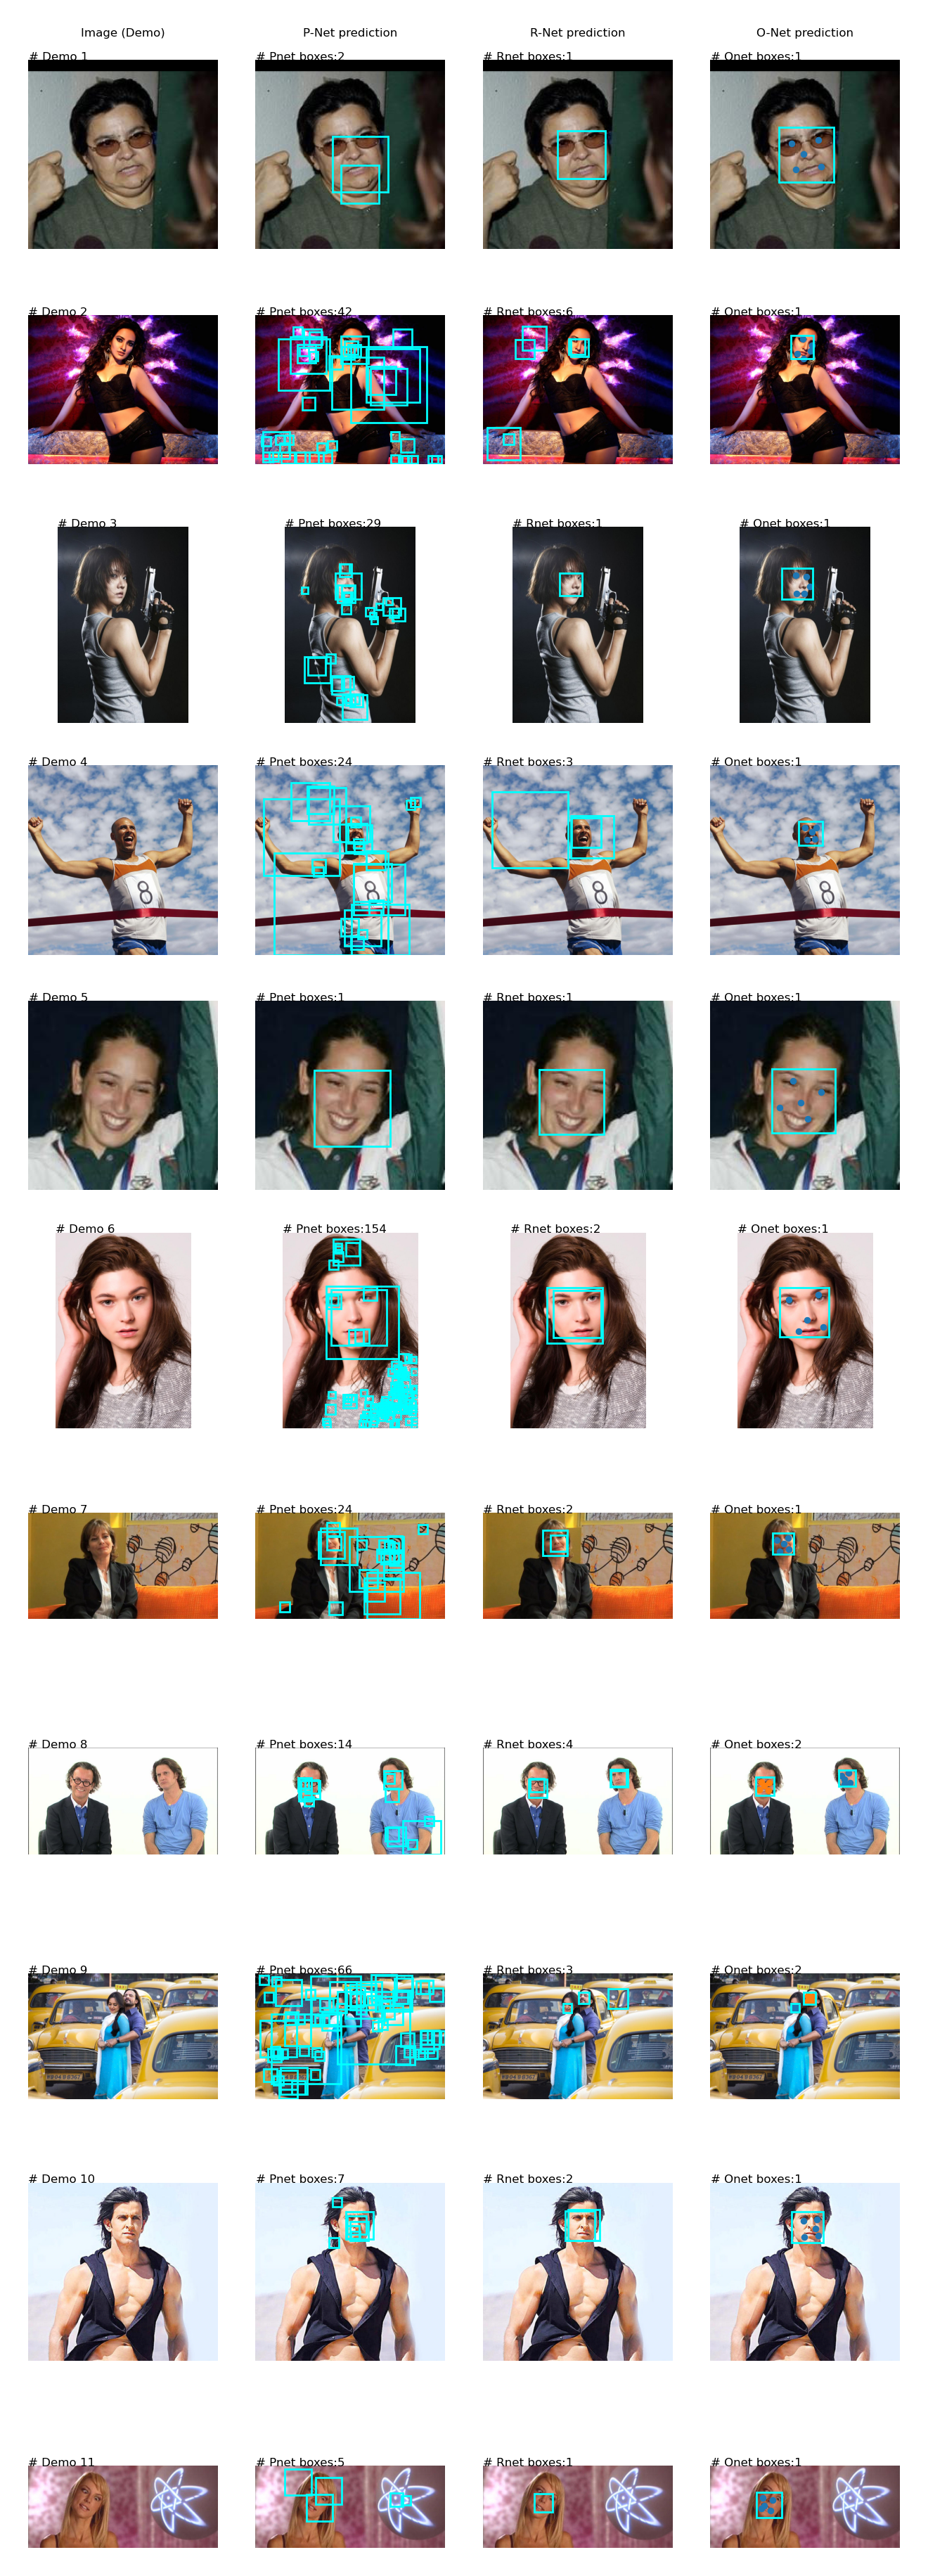

In [12]:
fig, ax = plt.subplots(len(demo_img_path),4,dpi = 400, figsize=(4,12))

for i in range(len(demo_img_path)):
    img = Image.open(demo_img_path[i])
    p_bounding_boxes = pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS)
    r_bounding_boxes=rnet_boxes(img, rnet, p_bounding_boxes, show_boxes=False)
    
    if r_bounding_boxes is not None and len(r_bounding_boxes) != 0:
        bounding_boxes = np.vstack((p_bounding_boxes, r_bounding_boxes))
    else:
        bounding_boxes=p_bounding_boxes
        
    try:
        o_bounding_boxes,ldmk=onet_boxes(img, onet,  bounding_boxes)
    except:
        o_bounding_boxes,ldmk=[],[]
    
    ax[i,0].imshow(img)  
    ax[i,0].text(0, 0, '# Demo '+str(i+1),fontsize=3)
    
    ax[i,1].imshow(img)
    ax[i,1].text(0, 0, '# Pnet boxes:'+str(len(p_bounding_boxes)),fontsize=3)
    for b in p_bounding_boxes[:100]:
        ax[i,1].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   
    
    ax[i,2].imshow(img)
    ax[i,2].text(0, 0, '# Rnet boxes:'+str(len(r_bounding_boxes)),fontsize=3)
    for b in r_bounding_boxes:
        ax[i,2].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   
        
    ax[i,3].imshow(img)
    ax[i,3].text(0, 0, '# Onet boxes:'+str(len(o_bounding_boxes)),fontsize=3)
    for b in o_bounding_boxes:
        ax[i,3].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5)) 
    for l in ldmk:    
        ax[i,3].scatter([l[j*2] for j in range(5)],[l[j*2+1] for j in range(5)],s=0.5)


for axes in ax.ravel():
    axes.axis('off')
ax[0][0].set_title("Image (Demo)",fontsize=3)
ax[0][1].set_title("P-Net prediction",fontsize=3)
ax[0][2].set_title("R-Net prediction",fontsize=3)
ax[0][3].set_title("O-Net prediction",fontsize=3)
fig.show()
fig.savefig('demo_Test.png')

## Use opencv to do the face alignment

In [13]:
def transformation_from_points(points1, points2):
    points1 = points1.astype(np.float64)
    points2 = points2.astype(np.float64)
    c1 = np.mean(points1, axis=0)
    c2 = np.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2
    s1 = np.std(points1)
    s2 = np.std(points2)
    points1 /= s1
    points2 /= s2
    U, S, Vt = np.linalg.svd(points1.T * points2)
    R = (U * Vt).T
    return np.vstack([np.hstack(((s2 / s1) * R,c2.T - (s2 / s1) * R * c1.T)),np.matrix([0., 0., 1.])])
 
def warp_im(img_im, orgi_landmarks,tar_landmarks):
    pts1 = np.float64(np.matrix([[point[0], point[1]] for point in orgi_landmarks]))
    pts2 = np.float64(np.matrix([[point[0], point[1]] for point in tar_landmarks]))
    M = transformation_from_points(pts1, pts2)
    dst = cv2.warpAffine(img_im, M[:2], (img_im.shape[1], img_im.shape[0]))
    return dst
 
def face_alignment(pic_path,pnet,rnet,onet):
 
    # Size Parameter
    lower_threshold = 100
    upper_threshold = 200
    
 
    pic_name_list = os.listdir(pic_path)
    for every_pic_name in pic_name_list:
        num = 0
        img_im = cv2.imread(osp.join(pic_path, every_pic_name))
        input_img=Image.open(osp.join(pic_path, every_pic_name))
        if img_im is None:
            continue
        else:
            shape = img_im.shape
            height = shape[0]
            width = shape[1]
            
            
            p_bounding_boxes = pnet_boxes(input_img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS)
            r_bounding_boxes=rnet_boxes(input_img, rnet, p_bounding_boxes, show_boxes=False)
            if r_bounding_boxes is not None and len(r_bounding_boxes) != 0:
                pr_bounding_boxes = np.vstack((p_bounding_boxes, r_bounding_boxes))
            else:
                pr_bounding_boxes=p_bounding_boxes
        
            try:
                bounding_boxes,points=onet_boxes(input_img, onet,  pr_bounding_boxes)
            except:
                bounding_boxes,points=[],[]
                
            
            if bounding_boxes.shape[0] > 0:
                for i in range(bounding_boxes.shape[0]):  
                    x1, y1, x2, y2 = int(min(bounding_boxes[i][0], min(points[i][0:10:2]))), \
                                     int(min(bounding_boxes[i][1], min(points[i][1:10:2]))), \
                                     int(max(bounding_boxes[i][2], max(points[i][0:10:2]))), \
                                     int(max(bounding_boxes[i][3], max(points[i][1:10:2])))
                                
                    new_x1 = max(int(1.50 * x1 - 0.50 * x2),0)
                    new_x2 = min(int(1.50 * x2 - 0.50 * x1),width-1)
                    new_y1 = max(int(1.50 * y1 - 0.50 * y2),0)
                    new_y2 = min(int(1.50 * y2 - 0.50 * y1),height-1)
              

                    left_eye_x = points[i][0:10:2][0]
                    right_eye_x = points[i][0:10:2][1]
                    nose_x = points[i][0:10:2][2]
                    left_mouth_x = points[i][0:10:2][3]
                    right_mouth_x = points[i][0:10:2][4]
                    left_eye_y = points[i][1:10:2][0]
                    right_eye_y = points[i][1:10:2][1]
                    nose_y = points[i][1:10:2][2]
                    left_mouth_y = points[i][1:10:2][3]
                    right_mouth_y = points[i][1:10:2][4]
 
                    new_left_eye_x = left_eye_x - new_x1
                    new_right_eye_x = right_eye_x - new_x1
                    new_nose_x = nose_x - new_x1
                    new_left_mouth_x = left_mouth_x - new_x1
                    new_right_mouth_x = right_mouth_x - new_x1
                    new_left_eye_y = left_eye_y - new_y1
                    new_right_eye_y = right_eye_y - new_y1
                    new_nose_y = nose_y - new_y1
                    new_left_mouth_y = left_mouth_y - new_y1
                    new_right_mouth_y = right_mouth_y - new_y1
 
                    face_landmarks = [[new_left_eye_x,new_left_eye_y], 
                                      [new_right_eye_x,new_right_eye_y],
                                      [new_nose_x,new_nose_y],
                                      [new_left_mouth_x,new_left_mouth_y],
                                      [new_right_mouth_x,new_right_mouth_y]]
                    face = img_im[new_y1: new_y2, new_x1: new_x2] 
                    dst1 = warp_im(face,face_landmarks,coord5point1) 
                    dst2 = warp_im(face,face_landmarks,coord5point2) 
                    crop_im1 = dst1[0:imgSize1[0],0:imgSize1[1]]
                    crop_im2 = dst2[0:imgSize2[0],0:imgSize2[1]]
                    cv2.imwrite(every_pic_name+ '_' + str(num) + '_align_112x96.jpg',crop_im1)
                    cv2.imwrite(every_pic_name+ '_' + str(num) + '_align_112x112.jpg',crop_im2)
                    num = num + 1

In [14]:
imgSize1 = [112,96]
imgSize2 = [112,112]
coord5point1 = [[30.2946, 51.6963],  # 112x96
               [65.5318, 51.6963],
               [48.0252, 71.7366],
               [33.5493, 92.3655],
               [62.7299, 92.3655]]
coord5point2 = [[30.2946+8.0000, 51.6963], # 112x112
               [65.5318+8.0000, 51.6963],
               [48.0252+8.0000, 71.7366],
               [33.5493+8.0000, 92.3655],
               [62.7299+8.0000, 92.3655]]

face_alignment(demo_folder_path,pnet,rnet,onet)

### Show the results

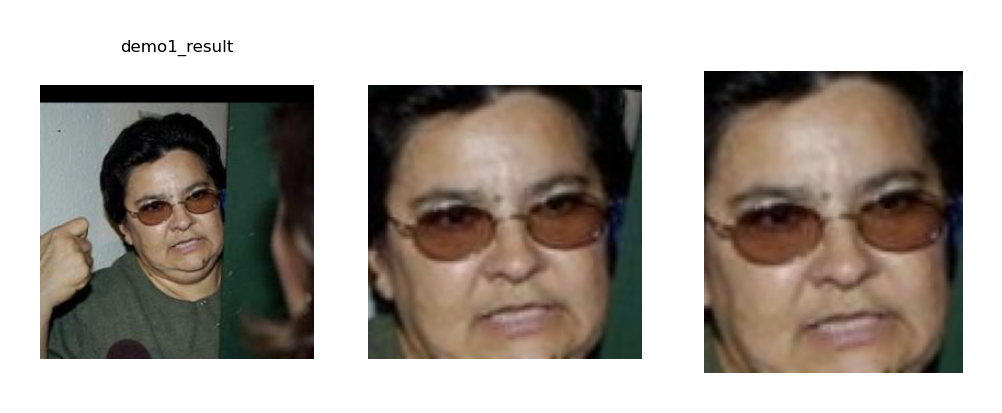

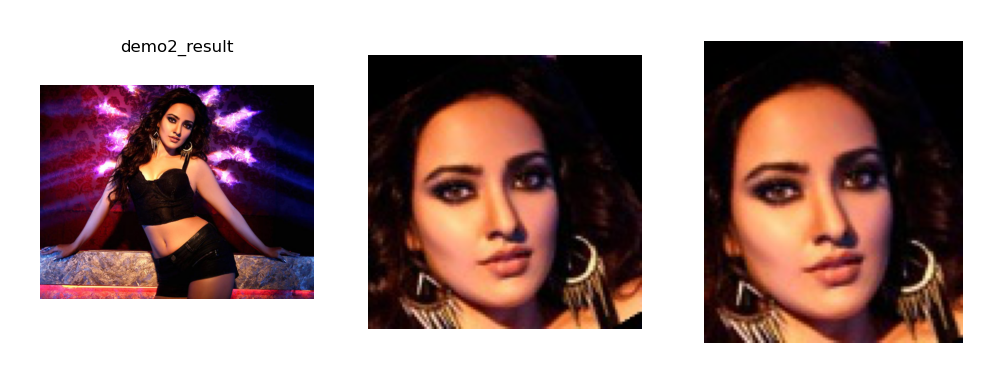

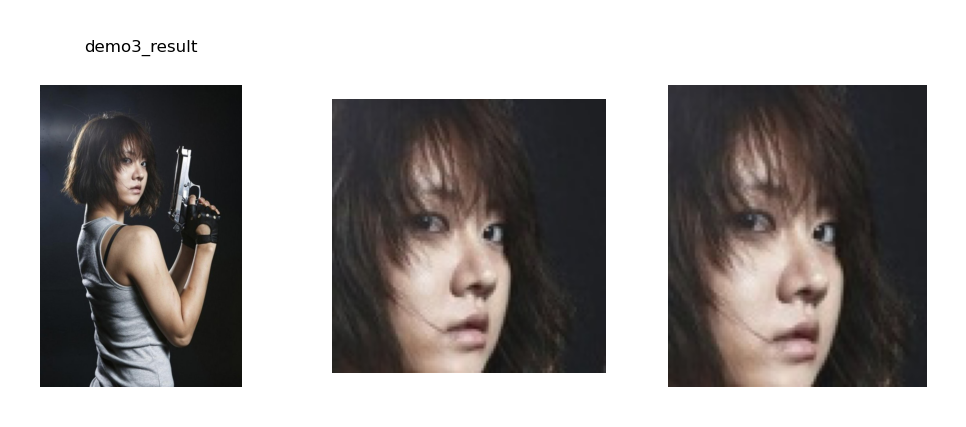

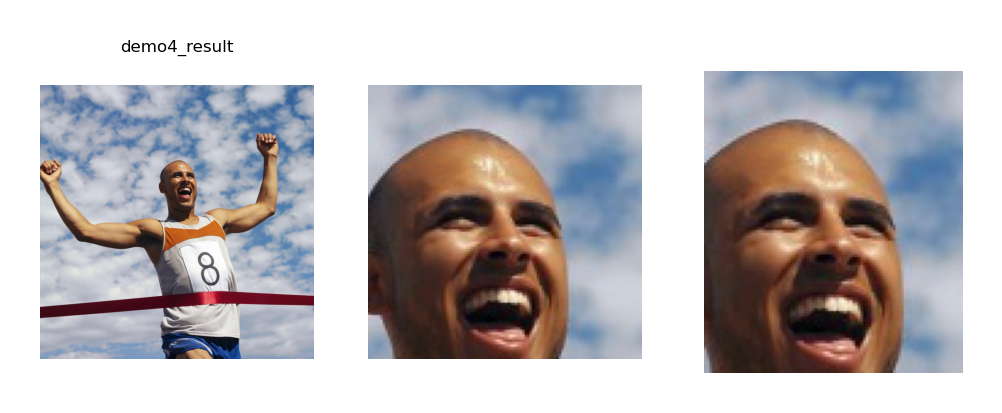

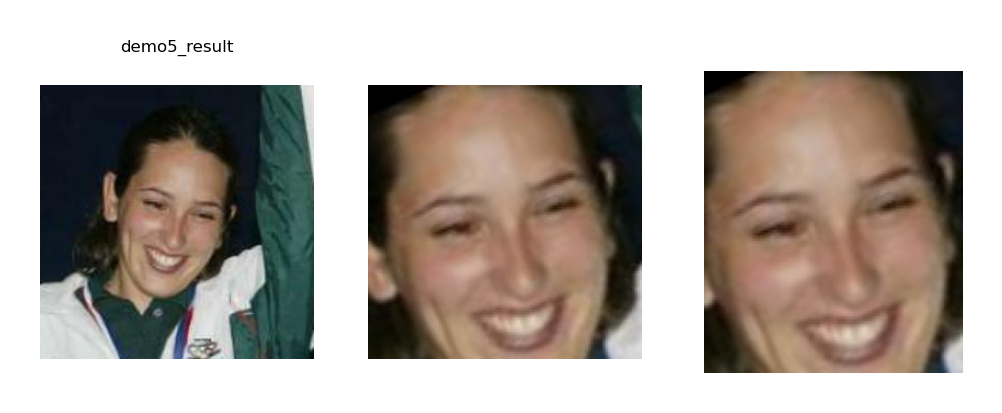

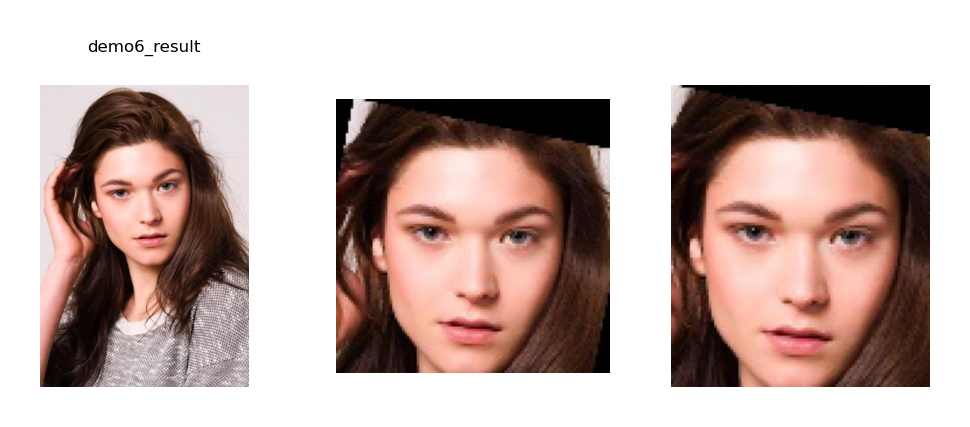

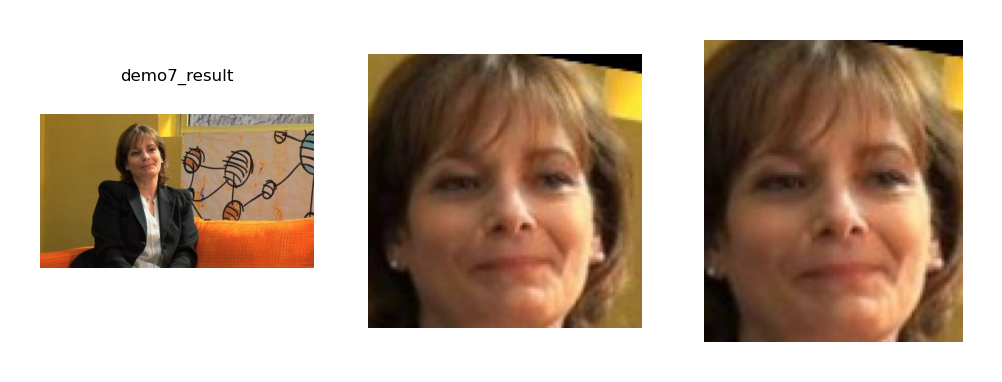

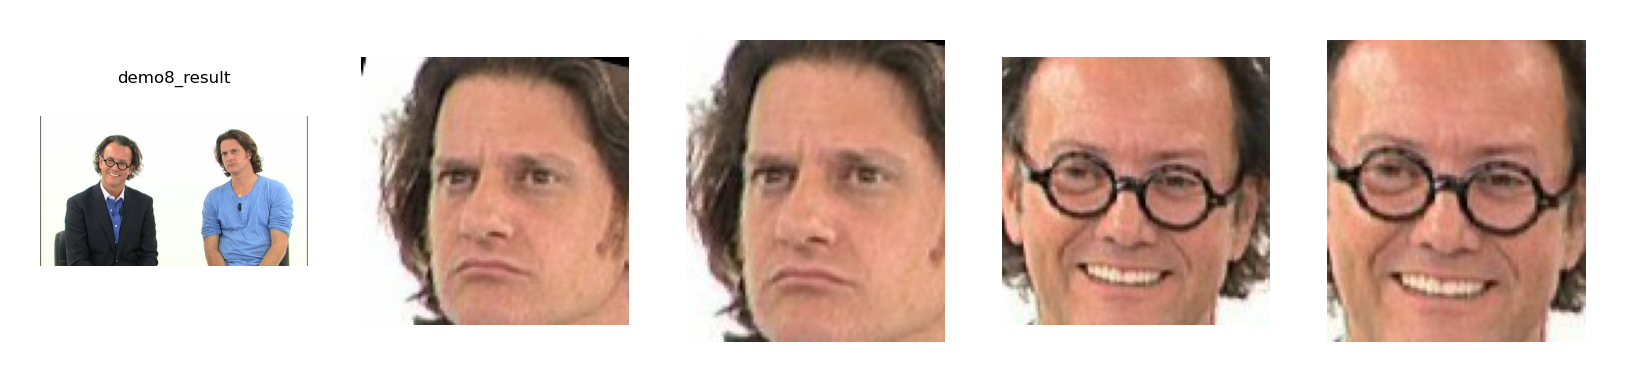

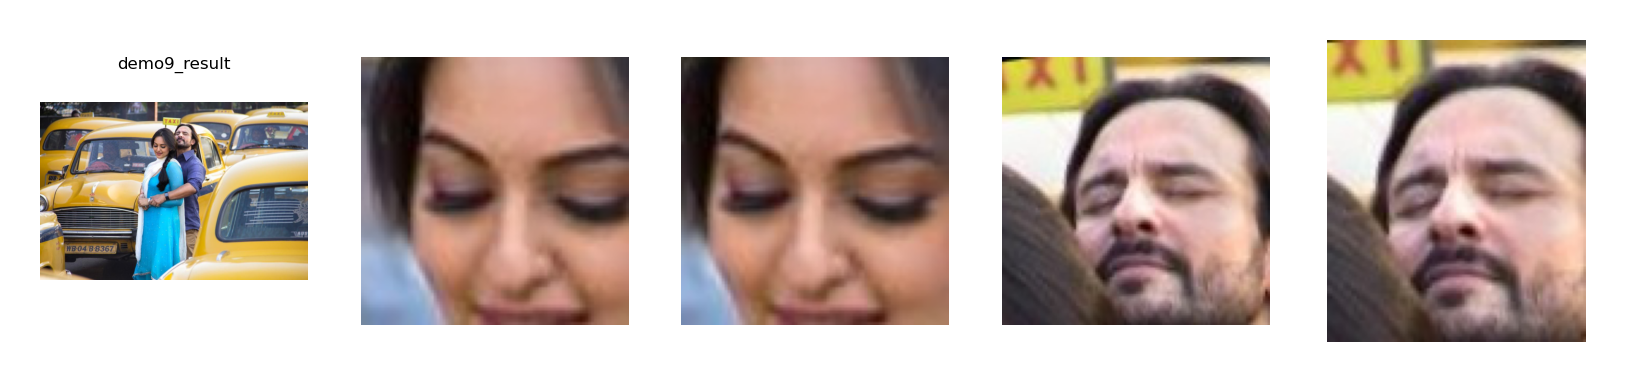

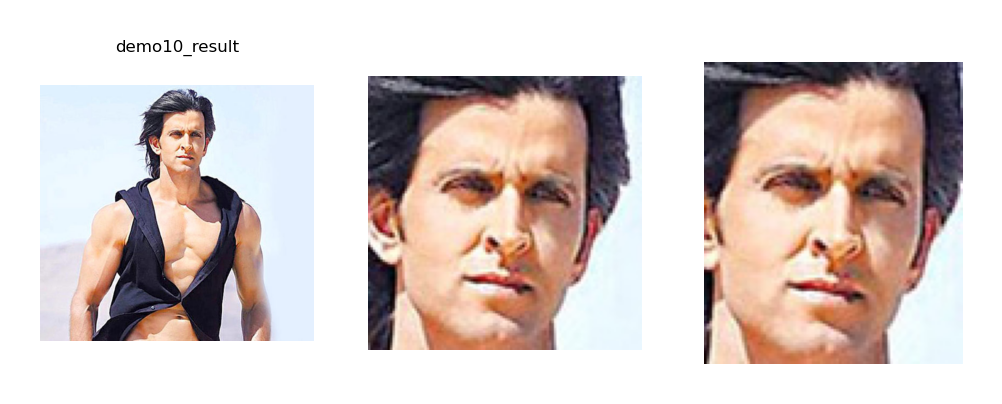

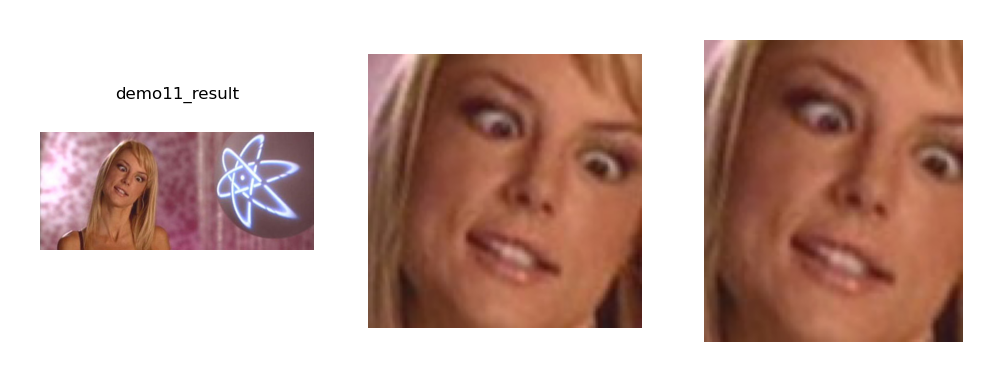

In [17]:
img_names=os.listdir(demo_folder_path)
img_names.sort()
crop_img_names=os.listdir('/kaggle/working')
crop_img_names.sort()
crop_img_names=np.array(crop_img_names)
num=1
for img_name in img_names:
    keeps=[i.startswith(img_name.split('.')[0]) for i in crop_img_names]
    show_names=crop_img_names[keeps]
    if len(show_names)>0:
        fig, ax = plt.subplots(1,len(show_names)+1,dpi = 400, figsize=(len(show_names)+1,1))
        ax[0].imshow(Image.open(osp.join(demo_folder_path, img_name))) 
        for i in range(1,len(show_names)+1):
            img_path=osp.join('/kaggle/working',show_names[i-1])
            img=Image.open(img_path)
            ax[i].imshow(img)
        for axes in ax.ravel():
            axes.axis('off')

        ax[0].set_title(f'demo{num}_result',fontsize=3)
        fig.show()    
        fig.savefig(f'demo{num}_result.png')
        num+=1